#Calculation fo Survival Fraction and TCP for varying dose/frac
Alpha (alpha/beta) will have a range of values


LQ - Model for individual fraction for patient *p*:
$$SF^p = exp(-\alpha^p d - \beta^p d^2)$$

$$TCP^p = exp(-N^p_0 \cdot S)$$
$$TCP^p = exp(-N^p_0 \cdot exp(-\alpha^p d - \beta^p d^2))$$

After n fractions:
$$SF^p_n = \prod^n_0 exp(-\alpha^p d_n - \beta^p d_n^2)$$
$$TCP^p_n = exp[-N^p_0 \cdot \prod^n_0 exp(-\alpha^p d_n - \beta^p d_n^2)]$$

For P patients:
$$TCP^p_n = \frac{\sum^P_p TCP^p_n}{P}$$
.

## Import necessary modules
Numpy for calcs
Matplotlib for plotting

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.html.widgets import FloatProgress
from IPython.display import display
%matplotlib qt
# qt if plot in seperate window
# inline if plot on page

## Set the number of d.p. displayed in numpy arrays
np.set_printoptions(precision=3)

### Function to calculate an alpha/beta from a normal distribution
User enters nominal alph/beta and SD
Beta is constant at 0.03 (from lit)
Returned is alpha

####Maybe better to accept an alpha value and a SD...? As this is what is likely published in the lit? Could then remove beta completely?

In [3]:
def alphacalc(alphabeta = 10, sd = 2, beta = 0.03):
    """Return alphabetanew and alpha from normal distribution as specified by sd.
    Default is alphabeta of 10, and sd of 2, beta = 0.03
    If a negative value is returned it is resampled until positive"""
    
    ## fixed beta at 0.03 as default in function
    
    ## get alpha beta to use from normal distribution
    if sd == 0:
        alphabetanew = alphabeta
    else:
        alphabetanew=np.random.normal(loc = alphabeta, scale = sd)
    
    ## make sure a positive value is returned
    while alphabetanew <= 0:
        alphabetanew=np.random.normal(loc = alphabeta, scale = sd)
    
    alpha = beta*alphabetanew
   
    return alpha, beta
## alpha/beta can be calced form the returned alpha and beta values

###Function to give a dose per fraction drawn from a normal distribution

In [4]:
def fracdose(dose = 2, shift = 0, sd = 0):
    """Return dose_actual from normal distribution around dose (Gy) as specified by sd (%) and shift (%).
    Default is dose = 2Gy, shift = 0%, and sd of 0%
    If a negative value is returned it is resampled until positive
    The standard deviation is of the nominal dose"""
    
    ## get actual dose to use from normal distribution based on shift
    
    dose_shift = dose + (dose*shift/100)
    
    ## if sd is zero, then no change to dose
    if sd == 0:
        dose_actual = dose_shift
        return dose_actual
    
    dose_actual=np.random.normal(loc = dose_shift, scale = (dose*sd/100))
    
    ## make sure a positive value is returned
    while dose_actual <= 0:
        dose_actual=np.random.normal(loc = dose_shift, scale = (dose*sd/100))
    
    return dose_actual

##Function to calculate SF

In [5]:
## Survival Fraction Calculation
def SFcalc(alpha = 0.1, beta = 0.03, dose = 2):
    """Return the SF with input values.
    Note this is for a single dose delivery.
    The product of multiple fractions shoudld be taken
    to give overall SF"""
    
    SF = np.exp(-(alpha*dose) - (beta*(dose**2)))
    
    return SF

##Function to Calculate TCP from given SF and starting number of cells

In [6]:
## TCP Calculation absed on cumulative SF
def TCPcalc(sf = 1E-9, n0=1E15):
    """Return the TCP with input values.
    Based on cumulative SF and N0"""
    
    TCP = np.exp(-n0*sf)
    
    return TCP

###Example plot of the different doses selected

In [7]:
## Could get the doses for each fraction in one go. Then calc all the SF in one go, then the TCP
dosevals = np.array([])
for i in range(0,10000):
    dosevals = np.append(dosevals,fracdose(dose = 2, shift=-25, sd=10))
    
#plt.hist(dosevals, bins=30)
#plt.xlim(0,3)

mean = np.mean(dosevals)
stdev = np.std(dosevals)
print("mean (Gy): " + str(mean))
print("stdev (Gy): " + str(stdev))

mean (Gy): 1.49991161387
stdev (Gy): 0.200020929914


<a id='Start'></a>
## Start of TCP calc
#[Go to End](#Ending)

### Define all Variables
These should be passed to overall TCP function

In [29]:
## Number of patients
n = 50

## alpha/beta mean
alphabeta_use = 10
## alpha/beta standard deviation
alphabeta_sd_use = 2

## Dose per fraction (Gy)
d = 2
## Mean Dose shift (%)
d_shift = 0
## dose sd (%)
d_sd = 1

## Number of tumour cells
n0 = 1E9

## Define Max dose for calcs (Gy) - Generally this will stay fixed to maintain consistency between plots
max_d= 100

###Create an array containing fraction number and nominal dose

In [30]:
## Calc Number of fractions to get to max dose (round up as always want an integer)
n_frac = np.ceil(max_d/d)

fractions = np.arange(1,n_frac+1)
#print(fractions)
nom_doses = np.arange(d,(d*n_frac)+d, step = d)
#print(nom_doses)

###Create a results array containing the number of patients

In [31]:
## This gives a column with the patient number and makes it easier to check values as going
patients = np.arange(0,n)+1
patients.shape=(n,1)
#print(patients)

###Calculate and add alpha values to results array

In [32]:
## empty array to store alpha values in
alpha_and_beta = np.array([])

for p in range(0,n):
    alpha_and_beta = np.append(alpha_and_beta,[alphacalc(alphabeta = alphabeta_use, sd=alphabeta_sd_use)])

## reshape to get a row per patient
alpha_and_beta = np.reshape(alpha_and_beta,(n,2))
#print(alpha_and_beta)

###Calculate a dose per fraction for each patient for x fractions

In [33]:
## Calculate Doses for all patients and all fractions
doses = np.array([])
for i in range(0,int(n*n_frac)):
    doses = np.append(doses,fracdose(dose = d, shift=d_shift, sd=d_sd))
doses = np.reshape(doses,(n,n_frac))
#print(doses)

In [34]:
## Combine all results into single array which may be easier to work with for analysis
results_wanted = (patients,alpha_and_beta, doses)
all_results = np.concatenate(results_wanted, axis=1)
#print(all_results)

###Calc SF for all individual doses with corresponding alpha and then calcualte cumulative SF

In [35]:
## Loop through the doses of the first patient (first row [0] of array)

SFs = np.array([])

for i in range(0,len(patients)): # loop through each patient (row)
    for j in range(0,int(n_frac)): # loop through each fraction for each patient (col)
        SFs = np.append(SFs,SFcalc(alpha_and_beta[i][0],alpha_and_beta[i][1],doses[i,j]))
    
SFs = np.reshape(SFs,(n,n_frac))

## GEt cumulative SF for each patient
SF_cum = np.cumprod(SFs, axis=1)

### Calculate TCP for individual patients and the population

In [36]:
## Calculate TCP for all individual patients and fractions
TCPs = TCPcalc(sf = SF_cum, n0=n0)

## Calculate population TCP by averaging down the columns
TCP_pop = np.mean(TCPs, axis = 0)

### Display plots of TCPs

In [38]:
## Plot of individual and population TCPs

dose_of_interest = 64
frac_of_interest = dose_of_interest/d

## all individuals
for i in range(0,len(TCPs)):
    plt.plot(nom_doses,TCPs[i], color = 'grey', alpha = 0.5)
## population
plt.plot(nom_doses,TCP_pop, color='black', linewidth='2', label='Population TCP')

## plot formatting
plt.xlim(0,max(nom_doses))
plt.ylim(0,1)
plt.xlabel('Dose (Gy)')
plt.ylabel('TCP')
plt.title('TCPs')
plt.legend(loc = 'best', fontsize = 'medium', framealpha = 1)
plt.axvline(frac_of_interest*d, color = 'black', ls='--')

plt.show()

In [39]:
## show the range of TCPs at a given fraction number (after a given nominal dose)

plt.hist(TCPs[:,frac_of_interest-1], bins=50, color='grey')
plt.show()
#print(np.mean(TCPs[:,frac_of_interest-1]))

## want to calcualte how the proportion that have TCP = 1.
## Is this just the same as reading off the TCP_pop value?

## Calculate Number of cured patients (TCP>0.999)

In [541]:
TCPs_of_interest = TCPs[:,frac_of_interest-1]

TCP_cure = (TCPs_of_interest > 0.5).sum()
print('Number of cured patients: ' + str(TCP_cure) + ' (' + str(100*TCP_cure/n) + '%)')


### For 1000 patient 70.5% have TCP>0.5 for 0 dose shift
### This reduces to 64.7% for a -2% dose shift.
### This means the gamma value is approx 3.

Number of cured patients: 705 (70.5%)


The plot above is the distribution of TCPs after 30 fractions
It can be seen that most patients ahve a TCP of 1 or 0.
This is due to the steep individual TCP curves.
There is a very fine line between a patient being 'cured' or 'not cured'.
So small changes in dose potentialy large impact on an individual patient.

## So Far...
Have:
- Patient number
- Alpha
- Beta (default value in function)
- Dose per fraction for all fractions
- SF after each fraction and cumulative
- TCP Calculated from the Cumulative SF for each individual patient.
- Array of fraction number and doses
- Get overall TCP from average of all patients.
- Plots of all TCPs

To do:
- Turn into large function?

<a id='Ending'></a>

##[Go to Start](#Start)

### Experimenting with lognormal distribution
More practical to use normal distribution as gradient unlikely ot be hugely different, and I am interested in the dose variaiton more than the a/b variation which will remain constant for the population.

10.02534237
12.7001778168


(0, 8000)

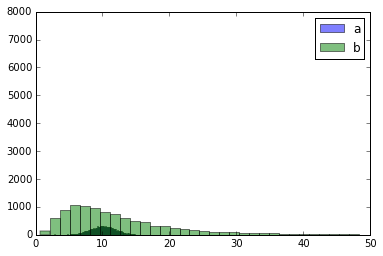

In [344]:
a = np.array([])
b = np.array([])

for i in range(0,10000):
    a = np.append(a,np.random.normal(loc = 10, scale = 2))
    b = np.append(b,np.random.lognormal(mean = np.log(10), sigma = np.log(2)))

print(np.mean(a))
print(np.mean(b))

plt.hist(a, label='a', bins=100, alpha=0.5)
plt.hist(b, label='b', bins=100, alpha=0.5)
plt.legend()
plt.xlim(0,50)
plt.ylim(0,8000)